In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

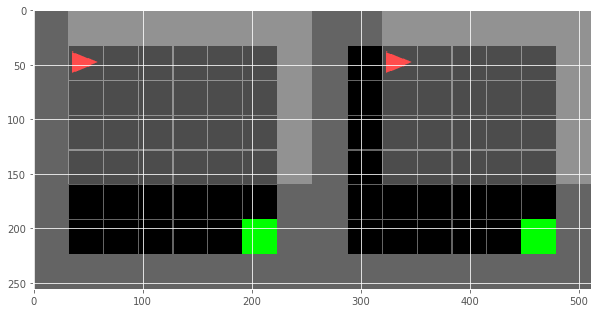

In [2]:
import gym
import gym_minigrid

env = gym.make('MiniGrid-Empty-8x8-v0')
env.reset()
before_img = env.render('rgb_array')
action = env.actions.forward
obs, reward, done, info = env.step(action)
after_img = env.render('rgb_array')

plt.imshow(np.concatenate([before_img, after_img], 1));

In [3]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Flatten image and remove walls

In [4]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

# max_env_steps = 100

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        # self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        
        flattened_grid = full_grid.ravel()
        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

# Add dense reward

In [5]:
import gym

def to_coords(state):
    idx = state[0:-1:3]
    n = int(np.sqrt(len(idx)))
    for i in range(n):
        for j in range(n):
            k = n*i + j
            if (idx[k] == 10) or (idx[k] == 8):
                return np.array([i+1, j+1])

class DenseRewardWrapper(gym.Wrapper):
    
    def reset(self):
        
        # Generate goal state
        self.env.unwrapped.agent_pos = np.array([self.grid_size-2, self.grid_size-2]) 
        self.goal_state = self.env.observation(self.env.unwrapped.gen_obs())
        # Set initial state
        self.env.reset()
        self.env.unwrapped.agent_pos = np.array([1, 1])
        
        # Return initial state 
        return self.env.observation(self.env.unwrapped.gen_obs())
    
    def __init__(self, env):
        self.goal_state = None
        self.grid_size = env.unwrapped.grid.encode().shape[0]
        super().__init__(env)
        
        
    def step(self, action):
        state = self.env.observation(self.env.unwrapped.gen_obs())
        next_state, reward, done, info = self.env.step(action)
        cur_pos, next_pos, goal_pos = to_coords(state), to_coords(next_state), to_coords(self.goal_state)
        dist1 = np.linalg.norm(cur_pos - goal_pos)
        dist2 = np.linalg.norm(next_pos - goal_pos)
        
        reward = (dist1 - dist2)
        reward = 1 - np.sqrt(2) if reward == 0 else reward
        
        if (next_pos == goal_pos).all() or (self.step_count  >= self.max_steps):
            done = True
        else: 
            done = False
        
        return next_state, reward, done, info
    
            
from gym.wrappers import Monitor

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name, dense=False):
    env = FlatObsWrapper(gym.make(env_name))
    if dense:
        env = DenseRewardWrapper(env)
    return wrap_env(env)

# DQN agent with replay buffer

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size, action_size, seed, hidden_size1=64, hidden_size2=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, action_size)

    def forward(self, state):
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [7]:
import torch.optim as optim
from collections import deque
import random


BATCH_SIZE = 128 # 32
UPDATE_STEP = 4 # 4
BUFFER_SIZE = 100000 # 100000
LEARNING_RATE = 5e-3 # 5e-3
GAMMA = 0.9 # 0.9
EPS_START = 1 # 1
EPS_END = 0.1 # 0.1
EPS_DECAY = 0.995 # 0.995
TAU=1e-3 # 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

class DQNAgent:
    """ An agent implementing Deep Q-Network algorithm"""
    
    def __init__(self, state_size, action_size, seed=42):
        """Initializes an Agent.
        
        Params:
        -------
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)
        self.action_size = action_size
        self.buffer = deque(maxlen=BUFFER_SIZE) 
        self.step = 0
        self.eps = EPS_START
        self.explore = True
        
    def reset_episode(self):
        """
        Resets episode and update epsilon decay
        """
        self.eps = max(EPS_END, EPS_DECAY*self.eps) 
        
    def learn(self):
        """
        Learns values-actions network
        
        """
        
        # Sample batch from replay buffer
        states, next_states, actions, rewards, dones = self.sample_batch()
        
        values = self.qnetwork_target.forward(next_states).detach()
        targets = rewards + GAMMA * values.max(1)[0].view(dones.size()) * (1 - dones)
        outputs = self.qnetwork_local.forward(states).gather(1, actions.long())
        self.optimizer.zero_grad()
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        self.optimizer.step()
    
    
    def update(self, state, action, reward, next_state, done):
        """
        Makes an update step of algorithm and append sars to buffer replay
        
        Params:
        -------
        state - current state
        action - action made
        reward - reward for an action
        next_state - next state from env
        done - episode finishing flag
        """
        self.buffer.append((state, next_state, action, reward, float(done)))
        
        self.step = (self.step+1)%UPDATE_STEP
        if self.step == 0:
            if len(self.buffer) > BATCH_SIZE:
                self.learn()
                self.reset_target_network()
        
    def reset_target_network(self):
        """
        Resets params of target network to values from local network
        """
        params = zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters())
        for target_param, local_param in params:
            updated_params = TAU*local_param.data + (1-TAU)*target_param.data
            target_param.data.copy_(updated_params)
        
        
    def act(self, state):
        """
        Selects action from state if epsilon-greedy way
        
        Params:
        state - current state
        
        """
        self.step+=1
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(torch.from_numpy(state).float().to(device))  
        self.qnetwork_local.train()
            
        if (random.random() > self.eps) and self.explore:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def sample_batch(self):
        """
        Samples a batch of experience from replay buffer random uniformily
        """
        batch = random.sample(self.buffer, k=BATCH_SIZE)
        f = lambda arr: torch.from_numpy(np.vstack(arr)).float().to(device)
        states, next_states, actions, rewards, dones = map(f, zip(*batch))
        return states, next_states, actions, rewards, dones

Running on device: cpu


In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def run_episode(env, agent, train_mode=True, show_steps=False):
    """
    A hepler function for running single episode
    """
    
    if not train_mode:
        agent.expore = False
    
    state = env.reset()                
    score = 0 
    done = False
    
    steps = 0
    while not done:
        steps+=1
        action = agent.act(state)                           
        next_state, reward, done, _  = env.step(action)                     
        agent.update(state, action, reward, next_state, done)
        score += reward                                     
        state = next_state 
        if (not train_mode) and show_steps:
            img = env.render('rgb_array')
            plt.imshow(img);
            plt.show()
            
    agent.reset_episode()
    env.close()
    
    if not train_mode:
        show_video()
    
    return score, steps

def run_episodes_and_display(env, agent, n_episodes=1000):
    """
    Runs a series of episode and display agent's performance
    """
    
    display_step = 100
    score = 0
    score_sum = 0
    scores = []
    steps = []
    for episode in range(1, n_episodes+1):
        score, step = run_episode(env, agent, train_mode=True)
        score_sum += score
        scores.append(score)
        steps.append(step)
        if episode%display_step==0:
            avg_score = score_sum/display_step
            print("Episode: {}. Average score: {}".format(episode, avg_score))
            score_sum = 0
            
    fig = plt.figure()
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Max Score')
    plt.xlabel('Episode #')
    plt.show()
    
    fig = plt.figure()
    plt.plot(np.arange(len(steps)), steps)
    plt.ylabel('Steps')
    plt.xlabel('Episode #')
    plt.show()

# Experimenting with different grids

# Small 5x5 grid for debugging

Episode: 100. Average score: 0.6468700000000004
Episode: 200. Average score: 0.8435799999999997
Episode: 300. Average score: 0.922239999999999
Episode: 400. Average score: 0.9313299999999987
Episode: 500. Average score: 0.9368199999999988


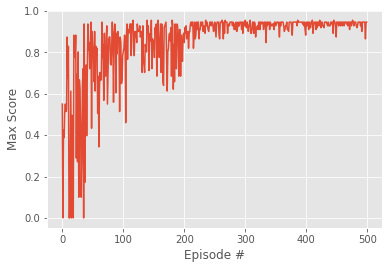

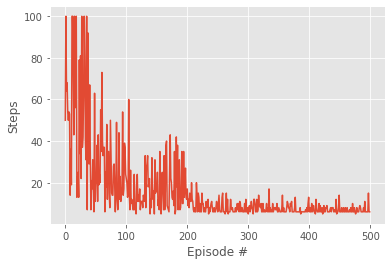

(0.946, 6)

In [9]:
env_name = 'MiniGrid-Empty-5x5-v0'
env = gen_wrapped_env(env_name, dense=False)
state_size = env.observation_space.shape[0]
action_size = 3 # env.action_space.n
dqn_agent = DQNAgent(state_size, action_size)
run_episodes_and_display(env, dqn_agent, n_episodes=500)

env = gen_wrapped_env(env_name)
run_episode(env, dqn_agent, train_mode=False)

# 8x8 Grid with sparse reward

Episode: 100. Average score: 0.5036484375
Episode: 200. Average score: 0.8180664062499998
Episode: 300. Average score: 0.8823671875000002
Episode: 400. Average score: 0.9068359374999999
Episode: 500. Average score: 0.9287031249999995
Episode: 600. Average score: 0.948249999999999
Episode: 700. Average score: 0.9549648437499993
Episode: 800. Average score: 0.9539101562499992
Episode: 900. Average score: 0.955105468749999
Episode: 1000. Average score: 0.9565468749999992


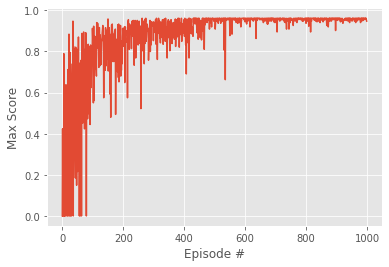

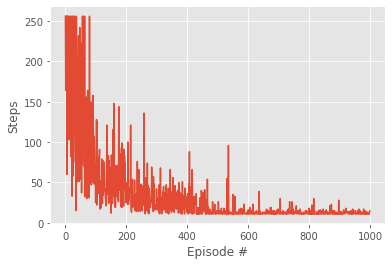

CPU times: user 1min 7s, sys: 789 ms, total: 1min 7s
Wall time: 1min 7s


(0.95078125, 14)

In [9]:
%%time

env_name = 'MiniGrid-Empty-8x8-v0'
env = gen_wrapped_env(env_name)
state_size = env.observation_space.shape[0]
action_size = 3 # env.action_space.n
dqn_agent = DQNAgent(state_size, action_size)
run_episodes_and_display(env, dqn_agent, n_episodes=1000)

env = gen_wrapped_env(env_name)
run_episode(env, dqn_agent, train_mode=False)

# 8x8 Grid with dense reward

Episode: 100. Average score: -15.922678250914611
Episode: 200. Average score: 1.8851140109543252
Episode: 300. Average score: 4.092872298402922
Episode: 400. Average score: 5.335512985522206
Episode: 500. Average score: 5.642031021678297


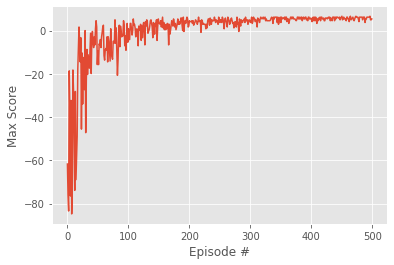

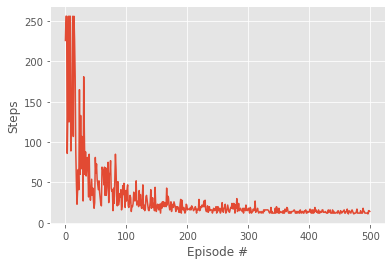

CPU times: user 41.3 s, sys: 404 ms, total: 41.7 s
Wall time: 41.8 s


(0.9578125, 12)

In [11]:
%%time

env_name = 'MiniGrid-Empty-8x8-v0'
env = gen_wrapped_env(env_name, dense=True)
state_size = env.observation_space.shape[0]
action_size = 3 # env.action_space.n
dqn_agent = DQNAgent(state_size, action_size)
run_episodes_and_display(env, dqn_agent, n_episodes=500)

env = gen_wrapped_env(env_name)
run_episode(env, dqn_agent, train_mode=False)

# Large 16x16 grid, dense reward

Episode: 100. Average score: -43.69097938702083
Episode: 200. Average score: 6.5631212407221
Episode: 300. Average score: 12.366253249569166
Episode: 400. Average score: 14.553300858899116
Episode: 500. Average score: 15.721383104791242


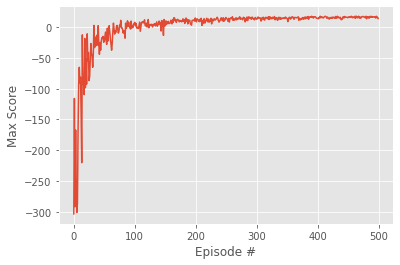

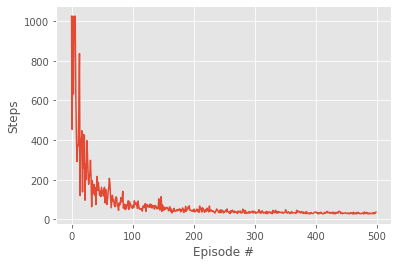

(0.9701171875, 34)

In [12]:
env_name = 'MiniGrid-Empty-16x16-v0'
env = gen_wrapped_env(env_name, dense=True)
state_size = env.observation_space.shape[0]
action_size = 3 # env.action_space.n
dqn_agent = DQNAgent(state_size, action_size)
run_episodes_and_display(env, dqn_agent, n_episodes=500)

env = gen_wrapped_env(env_name)
run_episode(env, dqn_agent, train_mode=False)

# Random pos 6x6

Episode: 100. Average score: -11.648681621146377
Episode: 200. Average score: 0.07565224964594766
Episode: 300. Average score: 1.8319177541078715
Episode: 400. Average score: 2.705908370715102
Episode: 500. Average score: 2.971005050633882


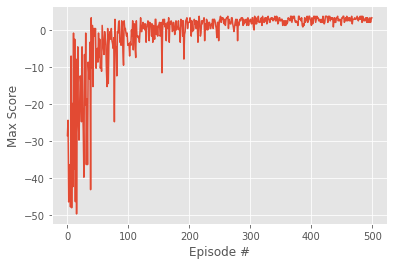

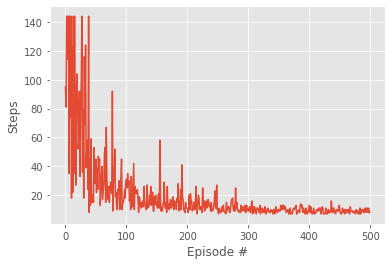

CPU times: user 22.2 s, sys: 174 ms, total: 22.4 s
Wall time: 22.5 s


(0.975, 4)

In [13]:
%%time
env_name = 'MiniGrid-Empty-Random-6x6-v0'
env = gen_wrapped_env(env_name, dense=True)
state_size = env.observation_space.shape[0]
action_size = 3 # env.action_space.n
dqn_agent = DQNAgent(state_size, action_size)
run_episodes_and_display(env, dqn_agent, n_episodes=500)

env = gen_wrapped_env(env_name)
run_episode(env, dqn_agent, train_mode=False)

# Four room

Episode: 100. Average score: -26.35230711790815
Episode: 200. Average score: -27.642761500571286
Episode: 300. Average score: -29.99033685666667
Episode: 400. Average score: -33.11261926479805
Episode: 500. Average score: -31.48341670215386
Episode: 600. Average score: -30.412174169575845
Episode: 700. Average score: -29.82049369415492
Episode: 800. Average score: -30.264954157030466
Episode: 900. Average score: -29.259388139306076
Episode: 1000. Average score: -31.006741042479803


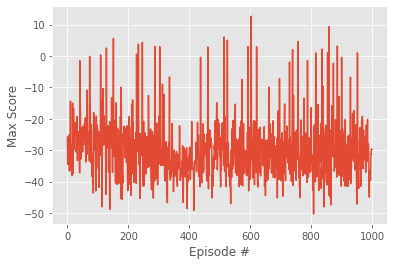

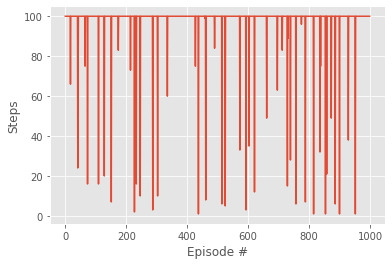

(0, 100)

In [14]:
env_name = 'MiniGrid-FourRooms-v0'
env = gen_wrapped_env(env_name, dense=True)
state_size = env.observation_space.shape[0]
action_size = 3 # env.action_space.n
dqn_agent = DQNAgent(state_size, action_size)
run_episodes_and_display(env, dqn_agent, n_episodes=1000)

env = gen_wrapped_env(env_name)
run_episode(env, dqn_agent, train_mode=False)

# Dynamic obstacles

Episode: 100. Average score: -66.35993133705189
Episode: 200. Average score: -8.729643482092559
Episode: 300. Average score: -0.7601745420342185
Episode: 400. Average score: 5.610430047263979
Episode: 500. Average score: 10.970353544371829
Episode: 600. Average score: 13.397645019878173
Episode: 700. Average score: 13.97340187157678
Episode: 800. Average score: 14.520163773909273
Episode: 900. Average score: 14.66513852073985
Episode: 1000. Average score: 14.917808793787449
Episode: 1100. Average score: 14.938519471906092
Episode: 1200. Average score: 15.174621202458757
Episode: 1300. Average score: 14.971656556895939
Episode: 1400. Average score: 15.058641404994294
Episode: 1500. Average score: 14.888813844421326
Episode: 1600. Average score: 15.01722004875698
Episode: 1700. Average score: 14.872245301926398
Episode: 1800. Average score: 14.984082963767133
Episode: 1900. Average score: 15.025504320004446
Episode: 2000. Average score: 15.369301576774117


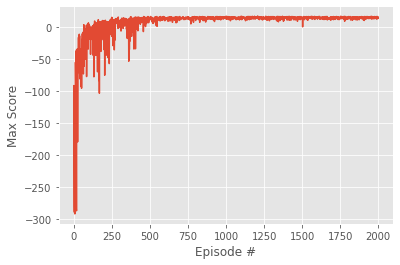

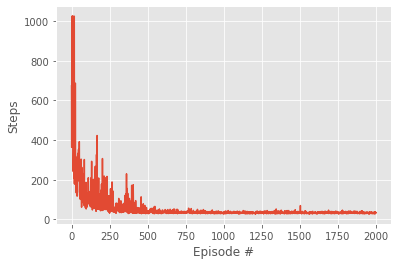

(-1, 10)

In [15]:
env_name = 'MiniGrid-Dynamic-Obstacles-16x16-v0'
env = gen_wrapped_env(env_name, dense=True)
state_size = env.observation_space.shape[0]
action_size = 3 # env.action_space.n
dqn_agent = DQNAgent(state_size, action_size)
run_episodes_and_display(env, dqn_agent, n_episodes=2000)

env = gen_wrapped_env(env_name)
run_episode(env, dqn_agent, train_mode=False)

In [25]:
env = gen_wrapped_env(env_name)
run_episode(env, dqn_agent, train_mode=False)

(0.97099609375, 33)